# Bottom up controls southern ocean from the CESM-LE

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import utils

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['TEMP_50m_mean_DJFmean','Fe_avg_50m_DJFmean','PAR_avg_50m_DJFmean',
             'spC_50m_zint_DJFmean','diatC_50m_zint_DJFmean',
             'spNPP_zint50m_DJFmean','diatNPP_zint50m_DJFmean',
            'graze_diat_zint50m_DJFmean','graze_sp_zint50m_DJFmean']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)


TEMP_50m_mean_DJFmean
Fe_avg_50m_DJFmean
PAR_avg_50m_DJFmean
spC_50m_zint_DJFmean
diatC_50m_zint_DJFmean
spNPP_zint50m_DJFmean
diatNPP_zint50m_DJFmean
graze_diat_zint50m_DJFmean
graze_sp_zint50m_DJFmean
CPU times: user 584 ms, sys: 48.3 ms, total: 632 ms
Wall time: 1.14 s


In [3]:
## convert NPP fields from mmolC/m2 cm/s to mmolC/m2/d
convert = 0.01 * 86400.
ds['diatNPP_zint50m'] = ds['diatNPP_zint50m'] * convert
ds['spNPP_zint50m'] = ds['spNPP_zint50m'] * convert

In [4]:
## convert grazing fields from mmolC/m2 cm/s to mmolC/m2/d
convert = 0.01 * 86400.
ds['graze_diat_zint50m'] = ds['graze_diat_zint50m'] * convert
ds['graze_sp_zint50m'] = ds['graze_sp_zint50m'] * convert

In [5]:
# divide NPP by biomass to estimate growth rate
ds['sp_growthrate'] = ds['spNPP_zint50m']/ds['spC_50m_zint']
ds['diat_growthrate'] = ds['diatNPP_zint50m']/ds['diatC_50m_zint']

ds.sp_growthrate.attrs = ds.spNPP_zint50m.attrs
ds.diat_growthrate.attrs = ds.diatNPP_zint50m.attrs
ds.sp_growthrate.attrs['long_name'] = 'Estimated growth rate of small phytoplankton (per day)'
ds.diat_growthrate.attrs['long_name'] = 'Estimated growth rate of diatoms (per day)'
ds.sp_growthrate.attrs['units'] = 'd^-1'
ds.diat_growthrate.attrs['units'] = 'd^-1'
 

In [6]:
# divide graze terms by biomass to estimate biomass specific grazing rate
ds['sp_grazerate'] = ds['graze_sp_zint50m']/ds['spC_50m_zint']
ds['diat_grazerate'] = ds['graze_diat_zint50m']/ds['diatC_50m_zint']

ds.sp_grazerate.attrs = ds.graze_sp_zint50m.attrs
ds.diat_grazerate.attrs = ds.graze_diat_zint50m.attrs
ds.sp_grazerate.attrs['long_name'] = 'Estimated grazing rate of small phytoplankton (per day)'
ds.diat_grazerate.attrs['long_name'] = 'Estimated grazing rate of diatoms (per day)'
ds.sp_grazerate.attrs['units'] = 'd^-1'
ds.diat_grazerate.attrs['units'] = 'd^-1'

### get pop grid

In [7]:
grid = pop_tools.get_grid('POP_gx1v6')

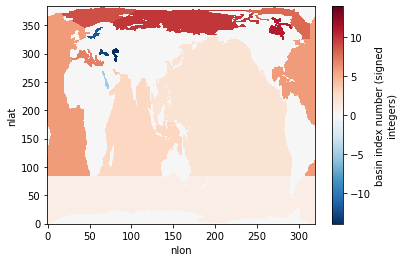

In [8]:
grid.REGION_MASK.plot()

In [9]:
lons = grid.TLONG
lats = grid.TLAT
years = ds.time.values
years

array([1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
       2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052,
       2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
       2064, 2065, 2066, 2067, 2068, 2069, 2070, 20

### mask out nans in ds

In [10]:
ds = ds.where(grid.REGION_MASK>0)

### Extract 1920s

In [11]:
ds.time.isel(time=slice(0,10)).values

array([1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930])

In [12]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### Extract 1990s

In [13]:
ds.time.isel(time=slice(70,80)).values

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000])

In [14]:
ds_1990s = ds.isel(time=slice(70,80)).mean(dim='time')

### Extract 2090s

In [15]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [16]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

### get masks for making averages

In [17]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

### Make timeseries

In [18]:
variables = ['TEMP_50m_mean','Fe_avg_50m','PAR_avg_50m',
             'spC_50m_zint','diatC_50m_zint',
             'spNPP_zint50m','diatNPP_zint50m',
             'diat_growthrate','sp_growthrate',
            'diat_grazerate','sp_grazerate',]

### ACC

In [19]:
%%time

vals_ACC_1920s = xr.Dataset({v: ds_1920s[v] for v in ['member_id']})
vals_ACC_1990s = xr.Dataset({v: ds_1990s[v] for v in ['member_id']})
vals_ACC_2090s = xr.Dataset({v: ds_2090s[v] for v in ['member_id']})

for v in variables:
    print(v)
    masked = ds_1920s[v].where(ds_masks.ACC_mask==1.)
    vals_ACC_1920s[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

    masked = ds_1990s[v].where(ds_masks.ACC_mask==1.)
    vals_ACC_1990s[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

    masked = ds_2090s[v].where(ds_masks.ACC_mask==1.)
    vals_ACC_2090s[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()


TEMP_50m_mean
Fe_avg_50m
PAR_avg_50m
spC_50m_zint
diatC_50m_zint
spNPP_zint50m
diatNPP_zint50m
diat_growthrate
sp_growthrate
diat_grazerate
sp_grazerate
CPU times: user 1min 11s, sys: 2min 47s, total: 3min 58s
Wall time: 6min 43s


### SIZ

In [20]:
%%time

vals_SIZ_1920s = xr.Dataset({v: ds_1920s[v] for v in ['member_id']})
vals_SIZ_1990s = xr.Dataset({v: ds_1990s[v] for v in ['member_id']})
vals_SIZ_2090s = xr.Dataset({v: ds_2090s[v] for v in ['member_id']})

for v in variables:
    print(v)
    masked = ds_1920s[v].where(ds_masks.SIZ_mask==1.)
    vals_SIZ_1920s[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

    masked = ds_1990s[v].where(ds_masks.SIZ_mask==1.)
    vals_SIZ_1990s[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

    masked = ds_2090s[v].where(ds_masks.SIZ_mask==1.)
    vals_SIZ_2090s[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()


TEMP_50m_mean
Fe_avg_50m
PAR_avg_50m
spC_50m_zint
diatC_50m_zint
spNPP_zint50m
diatNPP_zint50m
diat_growthrate
sp_growthrate
diat_grazerate
sp_grazerate
CPU times: user 1min 10s, sys: 2min 46s, total: 3min 57s
Wall time: 6min 17s


In [21]:
vals_SIZ_1920s_ens_mean = vals_SIZ_1920s.mean(dim='member_id')
vals_SIZ_2090s_ens_mean = vals_SIZ_2090s.mean(dim='member_id')

In [22]:
vals_ACC_1920s_ens_mean = vals_ACC_1920s.mean(dim='member_id')
vals_ACC_2090s_ens_mean = vals_ACC_2090s.mean(dim='member_id')

In [23]:
vals_SIZ_1920s_ens_mean

<xarray.Dataset>
Dimensions:          ()
Data variables:
    TEMP_50m_mean    float64 -1.153
    Fe_avg_50m       float64 0.0001442
    PAR_avg_50m      float64 14.43
    spC_50m_zint     float64 95.74
    diatC_50m_zint   float64 150.4
    spNPP_zint50m    float64 15.94
    diatNPP_zint50m  float64 20.3
    diat_growthrate  float64 0.1379
    sp_growthrate    float64 0.1656
    diat_grazerate   float64 0.1058
    sp_grazerate     float64 0.14

In [24]:
vals_SIZ_2090s_ens_mean

<xarray.Dataset>
Dimensions:          ()
Data variables:
    TEMP_50m_mean    float64 0.4325
    Fe_avg_50m       float64 0.0001162
    PAR_avg_50m      float64 22.78
    spC_50m_zint     float64 99.36
    diatC_50m_zint   float64 132.8
    spNPP_zint50m    float64 17.88
    diatNPP_zint50m  float64 18.77
    diat_growthrate  float64 0.1452
    sp_growthrate    float64 0.1843
    diat_grazerate   float64 0.1197
    sp_grazerate     float64 0.1643

In [25]:
vals_ACC_1920s_ens_mean

<xarray.Dataset>
Dimensions:          ()
Data variables:
    TEMP_50m_mean    float64 4.826
    Fe_avg_50m       float64 0.0001373
    PAR_avg_50m      float64 32.45
    spC_50m_zint     float64 86.41
    diatC_50m_zint   float64 78.18
    spNPP_zint50m    float64 22.68
    diatNPP_zint50m  float64 17.0
    diat_growthrate  float64 0.2506
    sp_growthrate    float64 0.3097
    diat_grazerate   float64 0.207
    sp_grazerate     float64 0.2724

In [26]:
vals_ACC_2090s_ens_mean

<xarray.Dataset>
Dimensions:          ()
Data variables:
    TEMP_50m_mean    float64 7.925
    Fe_avg_50m       float64 0.0001498
    PAR_avg_50m      float64 30.74
    spC_50m_zint     float64 47.32
    diatC_50m_zint   float64 105.3
    spNPP_zint50m    float64 17.71
    diatNPP_zint50m  float64 25.12
    diat_growthrate  float64 0.3093
    sp_growthrate    float64 0.4027
    diat_grazerate   float64 0.2543
    sp_grazerate     float64 0.364

In [27]:
delta_ACC_vals = vals_ACC_2090s_ens_mean - vals_ACC_1920s_ens_mean

In [28]:
delta_SIZ_vals = vals_SIZ_2090s_ens_mean - vals_SIZ_1920s_ens_mean

In [29]:
delta_ACC_vals.TEMP_50m_mean.values

array(3.09969498)

In [30]:
delta_SIZ_vals

<xarray.Dataset>
Dimensions:          ()
Data variables:
    TEMP_50m_mean    float64 1.586
    Fe_avg_50m       float64 -2.796e-05
    PAR_avg_50m      float64 8.349
    spC_50m_zint     float64 3.62
    diatC_50m_zint   float64 -17.53
    spNPP_zint50m    float64 1.936
    diatNPP_zint50m  float64 -1.528
    diat_growthrate  float64 0.007294
    sp_growthrate    float64 0.01868
    diat_grazerate   float64 0.01394
    sp_grazerate     float64 0.02427

In [31]:
[delta_ACC_vals.diat_growthrate.values,delta_SIZ_vals.diat_growthrate.values]

[array(0.05867281), array(0.00729421)]

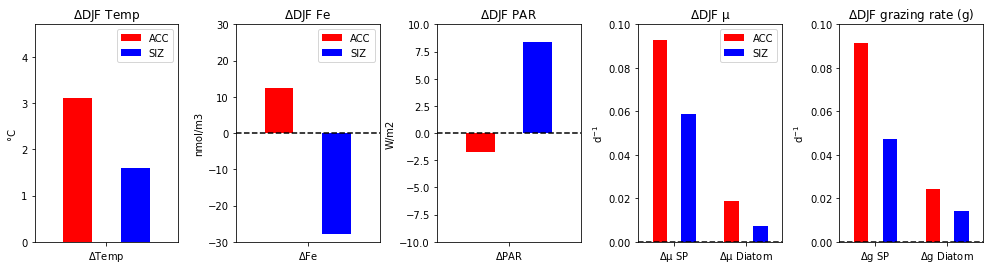

In [34]:
fig = plt.figure(figsize=(17,4))

#labels = ['${\Delta}$Temp','${\Delta}$Fe','${\Delta}$PAR','${\Delta}$µ SP','${\Delta}$µ Diatom']
########### temp
ax = fig.add_subplot(1,5,1)

labels = ['${\Delta}$Temp']
xvals = np.arange(len(labels))  # the label locations
width = 0.2 # the width of the bars
ax.set_xlim(-0.5,0.5)
ax.set_ylim(0,4.7)

rects1 = ax.bar(xvals - width/2 -0.1, delta_ACC_vals.TEMP_50m_mean.values, width, label='ACC',color='red')
rects2 = ax.bar(xvals + width/2 +0.1, delta_SIZ_vals.TEMP_50m_mean.values, width, label='SIZ',color='blue')

ax.set_ylabel('°C')
ax.set_title('${\Delta}$DJF Temp')
ax.set_xticks(xvals)
ax.set_xticklabels(labels)
ax.legend()

######## Fe
ax = fig.add_subplot(1,5,2)

labels = ['${\Delta}$Fe']
xvals = np.arange(len(labels))  # the label locations
width = 0.2 # the width of the bars
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-30,30)

rects1 = ax.bar(xvals - width/2 -0.1, delta_ACC_vals.Fe_avg_50m * 1e6, width, label='ACC',color='red')
rects2 = ax.bar(xvals + width/2 +0.1, delta_SIZ_vals.Fe_avg_50m * 1e6, width, label='SIZ',color='blue')

ax.set_ylabel('nmol/m3')
ax.set_title('${\Delta}$DJF Fe')
ax.set_xticks(xvals)
ax.set_xticklabels(labels)
ax.axhline(y=0, color='black', linestyle='--')
ax.legend()

######## PAR
ax = fig.add_subplot(1,5,3)

labels = ['${\Delta}$PAR']
xvals = np.arange(len(labels))  # the label locations
width = 0.2 # the width of the bars
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-10,10)

rects1 = ax.bar(xvals - width/2 -0.1, delta_ACC_vals.PAR_avg_50m, width, label='ACC',color='red')
rects2 = ax.bar(xvals + width/2 +0.1, delta_SIZ_vals.PAR_avg_50m, width, label='SIZ',color='blue')

ax.set_ylabel('W/m2')
ax.set_title('${\Delta}$DJF PAR')
ax.set_xticks(xvals)
ax.set_xticklabels(labels)
ax.axhline(y=0, color='black', linestyle='--')


######## µ SP & diatom
ax = fig.add_subplot(1,5,4)

labels = ['${\Delta}$µ SP','${\Delta}$µ Diatom']
xvals = np.arange(len(labels))  # the label locations
width = 0.2 # the width of the bars
ax.set_xlim(-0.5,1.5)
ax.set_ylim(0,0.1)

rects1 = ax.bar(xvals - width/2 -0.1, [delta_ACC_vals.sp_growthrate,delta_SIZ_vals.sp_growthrate], width, label='ACC',color='red')
rects2 = ax.bar(xvals + width/2 +0.1, [delta_ACC_vals.diat_growthrate,delta_SIZ_vals.diat_growthrate], width, label='SIZ',color='blue')

ax.set_ylabel('d$^{-1}$')
ax.set_title('${\Delta}$DJF µ')
ax.set_xticks(xvals)
ax.set_xticklabels(labels)
ax.axhline(y=0, color='black', linestyle='--')

ax.legend()


######## grazing rate SP & diatom
ax = fig.add_subplot(1,5,5)

labels = ['${\Delta}$g SP','${\Delta}$g Diatom']
xvals = np.arange(len(labels))  # the label locations
width = 0.2 # the width of the bars
ax.set_xlim(-0.5,1.5)
ax.set_ylim(0,0.1)

rects1 = ax.bar(xvals - width/2 -0.1, [delta_ACC_vals.sp_grazerate,delta_SIZ_vals.sp_grazerate], width, label='ACC',color='red')
rects2 = ax.bar(xvals + width/2 +0.1, [delta_ACC_vals.diat_grazerate,delta_SIZ_vals.diat_grazerate], width, label='SIZ',color='blue')

ax.set_ylabel('d$^{-1}$')
ax.set_title('${\Delta}$DJF grazing rate (g)')
ax.set_xticks(xvals)
ax.set_xticklabels(labels)
ax.axhline(y=0, color='black', linestyle='--')


fig.subplots_adjust(wspace=0.4)